## Import Pandas library and load the file data into the notebook

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

p1 = pd.read_excel("Case Input Data.xlsx", sheet_name="Period1")
p2 = pd.read_excel("Case Input Data.xlsx", sheet_name="Period2")
print(p1.info())
print(p2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4052 entries, 0 to 4051
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   4052 non-null   int64  
 1   Rating               4052 non-null   object 
 2   PD                   4052 non-null   float64
 3   LGD                  4052 non-null   float64
 4   Original Exposure    4052 non-null   float64
 5   EAD Amount           4052 non-null   float64
 6   CCF                  4052 non-null   float64
 7   RWA                  4052 non-null   float64
 8   Capital Requirement  4052 non-null   float64
 9   Expected Loss        4052 non-null   float64
 10  EAD x PD             4052 non-null   float64
 11  EAD x LGD            4052 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 380.0+ KB


In [3]:
# Calculate risk weights for both periods
p1['Risk Weight'] = p1['RWA'] / p1['EAD Amount']
p2['Risk Weight'] = p2['RWA'] / p2['EAD Amount']

# Fix the NaN occurences due to division by zero
p1.loc[p1['EAD Amount']==0, 'Risk Weight'] = 0
p2.loc[p2['EAD Amount']==0, 'Risk Weight'] = 0

# Full join of periods 1 and 2
df = pd.merge(p1, p2, how='outer', on='ID')

## Slicing the data into old, former and old clients

In [4]:
new_clients    = pd.DataFrame(df[(df['Rating_x'].isnull()==True) & (df['Rating_y'].isnull()==False)])
former_clients = pd.DataFrame(df[(df['Rating_x'].isnull()==False) & (df['Rating_y'].isnull()==True)])
old_clients    = pd.DataFrame(df[(df['Rating_x'].isnull()==False) & (df['Rating_y'].isnull()==False)])



### Analyzing the changes in terms of Risk Weights

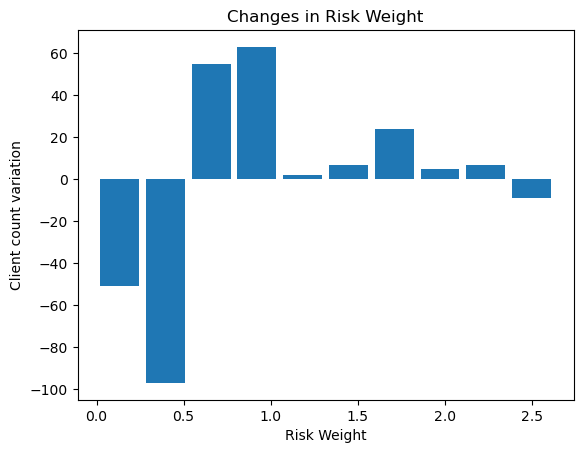

In [5]:
# Overal shift on Risk Weights, regardless of exposure (Defaults not taken into account)

p1_counts, p1_bins = np.histogram(p1.loc[p1['PD'] < 1.00, 'Risk Weight'])
p2_counts, p2_bins = np.histogram(p2.loc[p2['PD'] < 1.00, 'Risk Weight'])
if all(p1_bins == p2_bins):
    bins = p1_bins
    counts = p2_counts - p1_counts

plt.hist(bins[:-1], bins, weights=counts, rwidth=0.85)
plt.title('Changes in Risk Weight')
plt.xlabel('Risk Weight')
plt.ylabel('Client count variation')
plt.savefig('../figures/RW_variations.pdf')

Text(0.5, 1.0, 'Changes in Probability of Default')

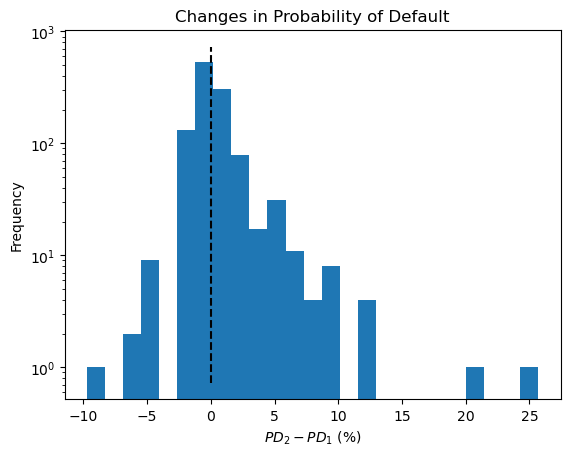

In [6]:
# Checking the Risk Weight distribution for old clients
old_clients.loc[(old_clients['PD_x'] < 1) & 
                (old_clients['PD_y'] < 1) & 
                (old_clients['PD_x'] != old_clients['PD_y'])
                ].apply(lambda x: 100 * (x['PD_y'] - x['PD_x']), axis=1).plot.hist(bins=25)
plt.yscale('log')
plt.plot([0, 0], plt.ylim(), ls='--', color='k')
plt.xlabel(r'$PD_2 - PD_1$'+' (%)')
plt.title('Changes in Probability of Default')

In [7]:
p1[p1['PD']==1]

,ID,Rating,PD,LGD,Original Exposure,EAD Amount,CCF,RWA,Capital Requirement,Expected Loss,EAD x PD,EAD x LGD,Risk Weight
7,9,PC0,1.0,0.449,0.002988,0.002988,1.000000,0.0,0.0,0.001342,0.002988,0.001342,0.0
8,10,PC0,1.0,0.450,1.960899,1.960899,1.000000,0.0,0.0,0.882405,1.960899,0.882405,0.0
15,17,PC0,1.0,0.450,17.743297,8.871654,0.500000,0.0,0.0,3.992244,8.871654,3.992244,0.0
59,61,PC0+,1.0,0.450,20690.654650,19922.558650,0.962877,0.0,0.0,8965.151392,19922.558650,8965.151392,0.0
64,67,PC0,1.0,0.450,64633.488009,7698.140402,0.119105,0.0,0.0,3464.163181,7698.140402,3464.163181,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,4103,PC0+,1.0,0.450,141.482692,141.482692,1.000000,0.0,0.0,63.667212,141.482692,63.667212,0.0
3561,4104,PC0+,1.0,0.450,681.775958,367.584635,0.539158,0.0,0.0,165.413086,367.584635,165.413086,0.0
3562,4105,PC0-,1.0,0.450,2394.934500,2394.934500,1.000000,0.0,0.0,1077.720525,2394.934500,1077.720525,0.0
3563,4106,PC0-,1.0,0.450,786.914221,786.914221,1.000000,0.0,0.0,354.111399,786.914221,354.111399,0.0


### Analyzing the changes in terms of Probability of default

Text(0.5, 1.0, 'Period 2')

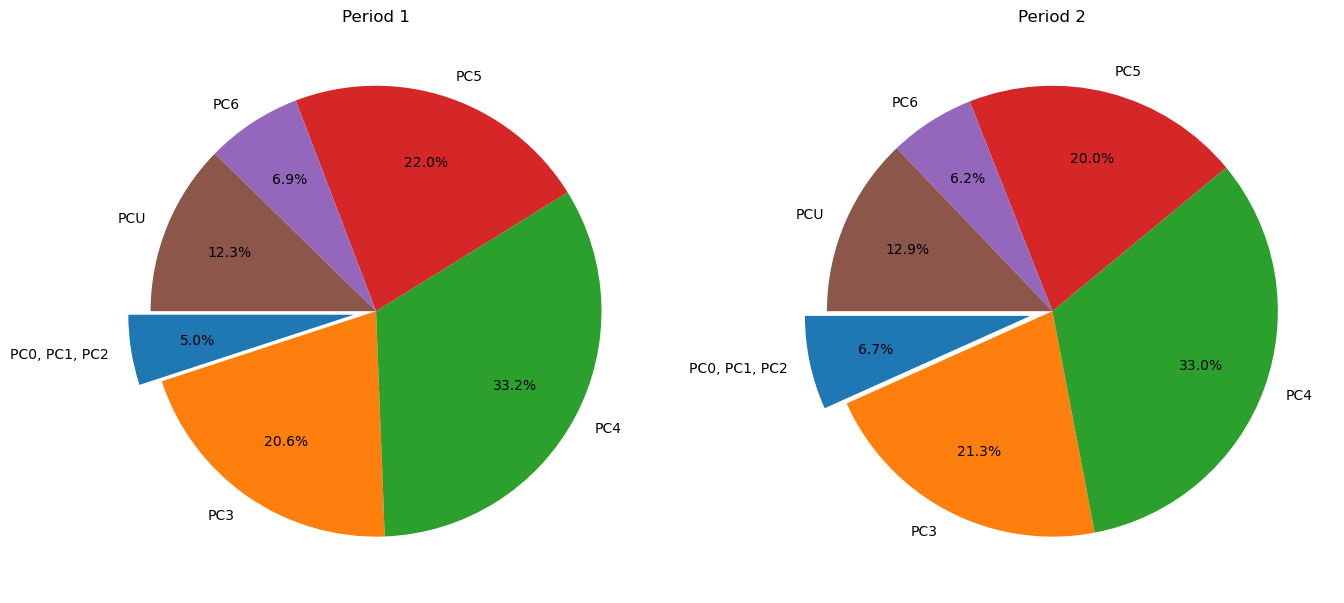

In [8]:
p1_categories = pd.DataFrame(p1[['ID', 'Rating']])
p1_categories['Rating Category'] = p1_categories['Rating']

p2_categories = pd.DataFrame(p2[['ID', 'Rating']])
p2_categories['Rating Category'] = p2_categories['Rating']

def categorize(rating: str) -> str:
    if rating[2] in ['0', '1', '2']:
        return 'PC0, PC1, PC2'
    else:
        return rating[:3]

p1_categories['Rating Category'] = p1_categories['Rating Category'].map(categorize)
p2_categories['Rating Category'] = p2_categories['Rating Category'].map(categorize)


# Making plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

explode = [0.0 for x in range(p1_categories['Rating Category'].value_counts().shape[0])]
explode[0] = 0.1
pie_data = p1_categories['Rating Category'].value_counts().sort_index()
x      = pie_data.values
labels = pie_data.index
ax1.pie(x, labels=labels, autopct='%1.1f%%', shadow=False, startangle=180, explode=explode, pctdistance=0.7)
ax1.set_title('Period 1')

pie_data = p2_categories['Rating Category'].value_counts().sort_index()
x      = pie_data.values
labels = pie_data.index
ax2.pie(x, labels=labels, autopct='%1.1f%%', shadow=False, startangle=180, explode=explode, pctdistance=0.7)
ax2.set_title('Period 2')


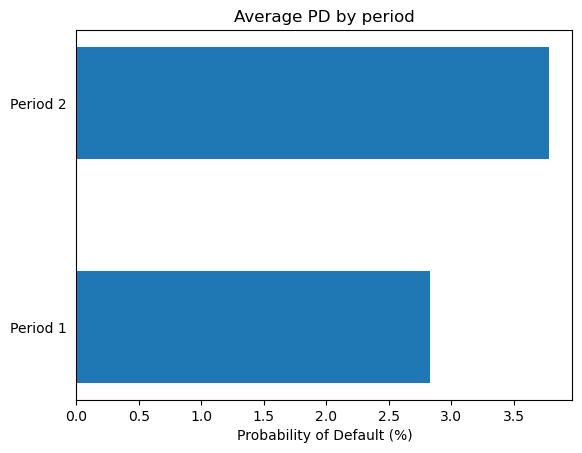

In [9]:
# Change in the average probability of default 

PD_periods = np.array([p1['PD'].mean(), p2['PD'].mean()]) * 100 
labels = ['Period 1', 'Period 2']

y_pos = np.arange(2)
plt.barh(y_pos, PD_periods, align='center', height=0.5)
plt.yticks(y_pos, labels=labels)
plt.xlabel('Probability of Default (%)')
plt.title('Average PD by period')
plt.tick_params(left=False)


In [10]:
PD1 = p1['EAD x PD'].sum() / p1['EAD Amount'].sum() * 100
PD2 = p2['EAD x PD'].sum() / p2['EAD Amount'].sum() * 100
PD2 / PD1

1.3199574259180675

### Analyzing the changes in terms of Expected Loss

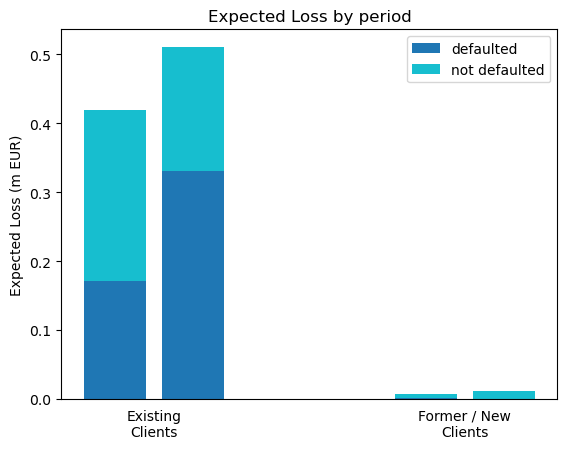

In [11]:
# Get expected loss from different groups
p1_EL_default = np.array([
    old_clients.loc[old_clients['PD_x']==1, 'Expected Loss_x'].sum(), 
    former_clients.loc[former_clients['PD_x']==1, 'Expected Loss_x'].sum()
    # df.loc[df['PD_x']==1, 'Expected Loss_x'].sum()
])
p2_EL_default = np.array([
    old_clients.loc[old_clients['PD_y']==1, 'Expected Loss_y'].sum(), 
    new_clients.loc[new_clients['PD_y']==1, 'Expected Loss_y'].sum()
    # df.loc[df['PD_y']==1, 'Expected Loss_y'].sum()
])
p1_EL_NO_default = np.array([
    old_clients.loc[old_clients['PD_x'] < 1, 'Expected Loss_x'].sum(), 
    former_clients.loc[former_clients['PD_x'] < 1, 'Expected Loss_x'].sum()
    # df.loc[df['PD_x'] < 1, 'Expected Loss_x'].sum()
])
p2_EL_NO_default = np.array([
    old_clients.loc[old_clients['PD_y'] < 1, 'Expected Loss_y'].sum(), 
    new_clients.loc[new_clients['PD_y'] < 1, 'Expected Loss_y'].sum()
    # df.loc[df['PD_y'] < 1, 'Expected Loss_y'].sum()
])


# even_pos = np.array([0, 1, 2])
even_pos = np.array([0, 1])
odd_pos  = even_pos + 0.25

# Stacked grouped bar chart
plt.bar(even_pos, p1_EL_default / 1e6   , align='center', width= 0.2, color='tab:blue', label='defaulted')
plt.bar(even_pos, p1_EL_NO_default / 1e6, align='center', width= 0.2, color='tab:cyan', bottom=p1_EL_default / 1e6, label='not defaulted')
plt.bar(odd_pos , p2_EL_default / 1e6   , align='center', width= 0.2, color='tab:blue')
plt.bar(odd_pos , p2_EL_NO_default / 1e6, align='center', width= 0.2, color='tab:cyan', bottom=p2_EL_default / 1e6)
 
# xlabels = ['Existing\nClients', 'Former / New\nClients', 'Total']
xlabels = ['Existing\nClients', 'Former / New\nClients']
plt.xticks(0.5*(even_pos + odd_pos), xlabels)
plt.tick_params(bottom=False)
plt.title('Expected Loss by period')
plt.ylabel('Expected Loss (m EUR)')
plt.legend(loc='upper right')
plt.show()

In [12]:
print(p2[p2['PD']==1]['Expected Loss'].sum() / p2['Expected Loss'].sum() * 100)

63.401772018538814


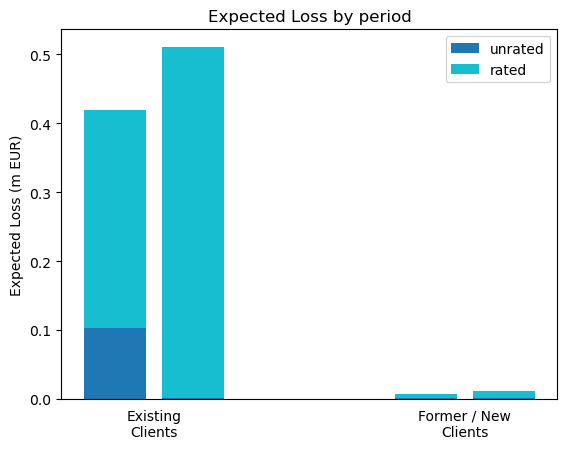

In [13]:
# Unrated customers
p1_EL_unrated = np.array([
    old_clients.loc[old_clients['Rating_x']=='PCU', 'Expected Loss_x'].sum(), 
    former_clients.loc[former_clients['Rating_x']=='PCU', 'Expected Loss_x'].sum()
])
p2_EL_unrated = np.array([
    old_clients.loc[old_clients['Rating_y']=='PCU', 'Expected Loss_y'].sum(), 
    new_clients.loc[new_clients['Rating_y']=='PCU', 'Expected Loss_y'].sum()
])
p1_EL_rated = np.array([
    old_clients.loc[old_clients['Rating_x']!='PCU', 'Expected Loss_x'].sum(), 
    former_clients.loc[former_clients['Rating_x']!='PCU', 'Expected Loss_x'].sum()
])
p2_EL_rated = np.array([
    old_clients.loc[old_clients['Rating_y']!='PCU', 'Expected Loss_y'].sum(), 
    new_clients.loc[new_clients['Rating_y']!='PCU', 'Expected Loss_y'].sum()
])


# even_pos = np.array([0, 1, 2])
even_pos = np.array([0, 1])
odd_pos  = even_pos + 0.25

# Stacked grouped bar chart
plt.bar(even_pos, p1_EL_unrated / 1e6, align='center', width= 0.2, color='tab:blue', label='unrated')
plt.bar(even_pos, p1_EL_rated / 1e6  , align='center', width= 0.2, color='tab:cyan', bottom=p1_EL_unrated / 1e6, label='rated')
plt.bar(odd_pos , p2_EL_unrated / 1e6, align='center', width= 0.2, color='tab:blue')
plt.bar(odd_pos , p2_EL_rated / 1e6  , align='center', width= 0.2, color='tab:cyan', bottom=p2_EL_unrated / 1e6)
 
# xlabels = ['Existing\nClients', 'Former / New\nClients', 'Total']
xlabels = ['Existing\nClients', 'Former / New\nClients']
plt.xticks(0.5*(even_pos + odd_pos), xlabels)
plt.tick_params(bottom=False)
plt.title('Expected Loss by period')
plt.ylabel('Expected Loss (m EUR)')
plt.legend(loc='upper right')
plt.show()



### Clients that had the most impact on capital consumption

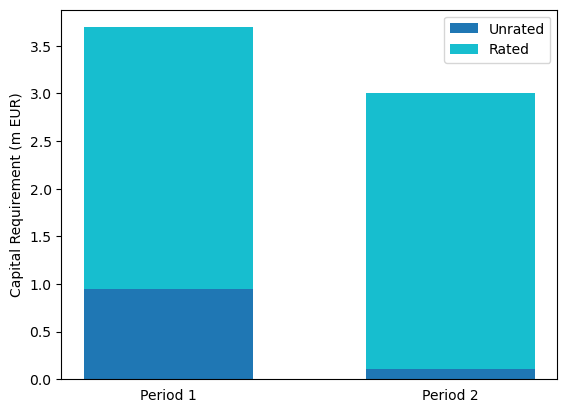

In [15]:
CapReq_rated = np.array([df.loc[df['Rating_x']!='PCU', 'Capital Requirement_x'].sum(), df.loc[df['Rating_x']!='PCU', 'Capital Requirement_y'].sum()])
CapReq_unrated = np.array([df.loc[df['Rating_x']=='PCU', 'Capital Requirement_x'].sum(), df.loc[df['Rating_x']=='PCU', 'Capital Requirement_y'].sum()])

plt.bar(np.arange(2), CapReq_unrated / 1e6, width=0.6, color='tab:blue', label='Unrated')
plt.bar(np.arange(2), CapReq_rated / 1e6, width=0.6, bottom=CapReq_unrated/1e6, color='tab:cyan', label='Rated')
labels = ['Period 1', 'Period 2']
plt.xticks(y_pos, labels=labels)
plt.ylabel('Capital Requirement (m EUR)')
plt.tick_params(bottom=False)
plt.legend()
plt.show()

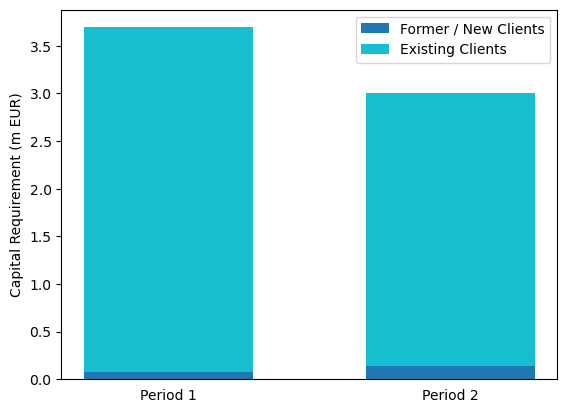

In [16]:
CapReq_new_former = np.array([former_clients['Capital Requirement_x'].sum(), new_clients['Capital Requirement_y'].sum()])
CapReq_old = np.array([old_clients['Capital Requirement_x'].sum(), old_clients['Capital Requirement_y'].sum()])

plt.bar(np.arange(2), CapReq_new_former / 1e6, width=0.6, color='tab:blue', label='Former / New Clients')
plt.bar(np.arange(2), CapReq_old / 1e6, width=0.6, bottom=CapReq_new_former/1e6, color='tab:cyan', label='Existing Clients')
labels = ['Period 1', 'Period 2']   
plt.xticks(y_pos, labels=labels)
plt.ylabel('Capital Requirement (m EUR)')
plt.tick_params(bottom=False)
plt.legend()
plt.show()

In [17]:
old_clients['CR_change'] = old_clients['Capital Requirement_y'] - old_clients['Capital Requirement_x']
old_clients['OE_change'] = old_clients['Original Exposure_y'] - old_clients['Original Exposure_x']
old_clients['PD_change'] = old_clients['PD_y'] - old_clients['PD_x']
old_clients[['ID','PD_change', 'OE_change', 'CR_change']].sort_values(by='CR_change', ascending=True).head(5)

,ID,PD_change,OE_change,CR_change
3039,3396,-0.02466,-2.079103e+06,-796950.325987
3040,3397,-0.02466,-5.491605e+04,-20802.132692
1527,1706,-0.00106,-3.746470e+05,-18591.161201
168,175,0.00000,-1.050377e+05,-14547.649790
62,64,0.98753,-3.017402e+04,-14043.626926


In [18]:
old_clients['CR_change'] = old_clients['Capital Requirement_y'] - old_clients['Capital Requirement_x']
old_clients['OE_change'] = old_clients['Original Exposure_y'] - old_clients['Original Exposure_x']
old_clients['PD_change'] = old_clients['PD_y'] - old_clients['PD_x']
old_clients[['ID','PD_change', 'OE_change', 'CR_change']].sort_values(by='CR_change', ascending=False).head(5)

,ID,PD_change,OE_change,CR_change
126,130,0.06248,136371.881581,31191.474366
687,757,0.00656,219559.492370,29455.218598
972,1090,0.00000,-49505.493013,16002.564227
1485,1662,0.00143,327973.632751,12930.098570
170,177,-0.93604,-16055.254465,12647.034305


In [25]:
print(f"Average PD for P1: {df['PD_x'].mean()}")
print(f"Average PD for P2: {df['PD_y'].mean()}")
print(f"PD2/PD1: {df['PD_y'].mean() / df['PD_x'].mean()}")

Average PD for P1: 0.028302467917077988
Average PD for P2: 0.03782378173828125
PD2/PD1: 1.3364128474272736


In [21]:
print(f"{df['Capital Requirement_x'].sum()}")
print(f"{df['Capital Requirement_y'].sum()}")
print(f"CAR2/CAR1: {df['Capital Requirement_y'].sum() / df['Capital Requirement_x'].sum() - 1}")

3694870.8325468916
3009194.4237399152
CAR2/CAR1: -0.1855752040821239


In [22]:
print(f"{df['Expected Loss_x'].sum()}")
print(f"{df['Expected Loss_y'].sum()}")
print(f"EL2/EL1: {df['Expected Loss_y'].sum() / df['Expected Loss_x'].sum()}")

425629.8452896017
522044.84341527283
EL2/EL1: 1.2265231143743447


Spans over 12 orders of magnitude!


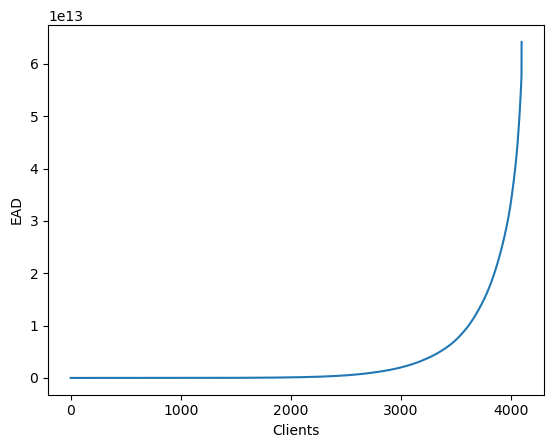

In [23]:
sorted_EAD = np.array(p2['EAD Amount'].sort_values().values)

running_total = np.cumsum(sorted_EAD)
plt.plot(running_total * 1e6)
plt.xlabel('Clients')
plt.ylabel('EAD')
# plt.yscale('log')
import math 
ratio = p2[p2['EAD Amount']!=0]['EAD Amount'].max() / p2[p2['EAD Amount']!=0]['EAD Amount'].min()
print( "Spans over {:d} orders of magnitude!".format(round(math.log10(ratio))) )